## IBM Data Science Professional Certificate Capstone Project

March 2021

## Table of Contents
### [1.Introduction](#1introduction)
### [2.Data](#2data)
### [3.Demographics analysis of San Francisco census tracts](#3demographicsanalysis) 

## 1. Introduction  <a name="1introduction"></a>

The goal of this project will be to find the best location for a Mexican restaurant in San Francisco, CA. As defined by the Investor this will be a restaurant aimed mainly at 30-49 year old clientele with income above 100k$ per annum. One of the main attractions will be the high quality of the food. At first we assume the the main customers will be the inhabitants of the neighboring areas, with a strong emphasis on clients with Mexican origin. 

Firstly I will analyse the the demographics of San Francisco to identify the market area with the optimum clientele base inline with the above assumptions. 
Secondly I will look into the selected area, examine the competition and pinpoint a more precise location. The analysis will be valueable for anyone planning to open a similar Mexican restaurant in San Francisco.


## 2. Data <a name="2data"></a>

I will use census tracts data obtained from openICPSR for the demographics analysis of the San Francisco - (National Neighborhood Data Archive (NaNDA): Socioeconomic Status and Demographic Characteristics of Census Tracts, United States, 2008-2017). ICPSR is an Inter-university Consortium for Political and Social Research.
Machine learning clustering on the relevant census tracts data will be carried out to identify the preferable neighboorhood.
The key data used to cluster the tracts will be:
* the average number of the population with income above 100k USD per year per square mile,  
* the average number of the Hispanic population per square mile- the majority of Hispanic population in SanFrancisco are of Mexican origin,
* the average number of the 30-49 year old population per square mile,

Additionally the land area of each tract will be taken into consideration.

The geojson census tracts file used for the maps was obtained from Metropolitan Transportation Commission (MTC) website, the transportation planning, coordinating and financing agency for the nine-county San Francisco Bay Area.

Information about the the competition in the selected area will be obtained with the Foursquare API. Two key factors will analysed using this data:
* location of other Mexican restaurants - the restaurant should be located as far as possible from the direct competitors,
* location of other restaurants - locating the restaurant next to other restaurants which are not direct competitors could be even beneficial (poossiblity of taking over their clients).

## 3. Methodology
* Initially I will convert the proportion of the population with income above 100k USD, Hispanic population and 30-49 year old population to average number of each type of population per square mile.
* My next step will be scaling the data using the minmax scaler in order to use it for clustering using the Kmeans algorithm,
* I will evaluate the impact of dividing the tracts into different number of clusters on the quality of the clusters using the yellowbrick library,
* Subsequently I will assess which cluster would be the most suitable, considering its demographics and size, for the location of the Mexican restaurant, 
* Finally I will use the data from the Foursquare api in order to pinpoint a more precise location of the restaurant, ensuring it is located as far as possible from the direct competitors 

## 4. Preparation of the demographics data. <a name="4demographicsdata"></a>

In [200]:
import pandas as pd
import numpy as np

Reading information about the demographics of San Francisco census tracts in terms of:
1. Persons per square mile, ACS 2013-2017 (popden13_17)
3. Proportion of people of Hispanic origin, ACS 2013-2017 (phispanic13_17)
3. Proportion of families with income greater than 100K, ACS 2013-2017 (inc_above_100k)
4. Proportion of population 30-49 years of age, ACS 2013-2017 (30-39_pop)
5. Land area of each tract (land_area)



In [201]:
pd.set_option('display.max_rows', 10)
demogr=pd.read_csv('nanda_ses_tract_2008-2017_04P.csv',dtype={'tract_fips10':str})
demogr['trint']=demogr['tract_fips10'].astype(int)
demogr_sf=demogr[(demogr['trint']<=6075990100) & (demogr['trint']>=6075010100)]
demogr.drop(columns=['trint'],inplace=True)
demogr_sf.reset_index(drop=True,inplace=True)
demogr_sf=demogr_sf.fillna(0)
demogr_sf.columns
demogr_sf_res=demogr_sf[['tract_fips10','popden13_17','phispanic13_17','pin5b_13_17','p30_3913_17','p40_4913_17','aland10']]
demogr_sf_res['30-49_pop']=demogr_sf_res['p30_3913_17']+demogr_sf_res['p40_4913_17']
demogr_sf_res.drop(columns=['p30_3913_17','p40_4913_17'],inplace=True)
demogr_sf_res.rename(columns={'pin5b_13_17':'inc_above_100k'},inplace=True)
demogr_sf_res.rename(columns={'tract_fips10':'trctid'},inplace=True)
demogr_sf_res.rename(columns={'aland10':'land_area'},inplace=True)
demogr_sf_res=demogr_sf_res[['trctid','popden13_17','phispanic13_17','inc_above_100k','30-49_pop','land_area']]
demogr_sf_res

<ipython-input-201-e78bb209f127>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  demogr_sf_res['30-49_pop']=demogr_sf_res['p30_3913_17']+demogr_sf_res['p40_4913_17']
/home/vladdie/miniconda3/envs/cap/lib/python3.9/site-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(
/home/vladdie/miniconda3/envs/cap/lib/python3.9/site-packages/pandas/core/frame.py:4441: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/

trctid  popden13_17  phispanic13_17  inc_above_100k  30-49_pop  \
0    06075010100   13232.0900        0.070078        0.430274   0.394505   
1    06075010200   21917.6300        0.030713        0.705506   0.366262   
2    06075010300   42257.9700        0.092529        0.510823   0.387252   
3    06075010400   35832.9800        0.117330        0.696329   0.435307   
4    06075010500   10194.5400        0.106652        0.635531   0.316983   
..           ...          ...             ...             ...        ...   
192  06075980401       0.0000        0.000000        0.000000   0.000000   
193  06075980501    1277.7750        0.187980        0.312500   0.148338   
194  06075980600     623.1144        0.173489        0.406250   0.249513   
195  06075980900     174.7661        0.239669        0.625000   0.632231   
196  06075990100       0.0000        0.000000        0.000000   0.000000   

     land_area  
0     0.299801  
1     0.199064  
2     0.103578  
3     0.129629  
4     0.263965  
..         ...  
192   0.161902  
193   0.612001  
194   0.823284  
195   1.384708  
196   0.000000  

[197 rows x 6 columns]

In [202]:
demogr_sf_res.describe()

popden13_17  phispanic13_17  inc_above_100k   30-49_pop   land_area
count     197.000000      197.000000      197.000000  197.000000  197.000000
mean    30705.343058        0.150408        0.539242    0.339857    0.237933
std     22463.860966        0.118301        0.220854    0.089740    0.278395
min         0.000000        0.000000        0.000000    0.000000    0.000000
25%     19862.460000        0.065402        0.381136    0.279339    0.113413
50%     26842.250000        0.111238        0.567935    0.335698    0.158258
75%     36030.870000        0.191804        0.705506    0.405110    0.254182
max    156680.800000        0.617953        0.947226    0.632231    2.358635

In [203]:
demogr_sf_res.dtypes

trctid             object
popden13_17       float64
phispanic13_17    float64
inc_above_100k    float64
30-49_pop         float64
land_area         float64
dtype: object

Calculating the the average number of persons of Hispanic origin, with income above 100k USD and aged 30-49 per square mile for each census tract.

In [204]:
demogr_sf_res_avg=pd.DataFrame()
demogr_sf_res_avg['trctid']=demogr_sf_res['trctid']
demogr_sf_res_avg['avg_hisp']=demogr_sf_res['popden13_17']*demogr_sf_res['phispanic13_17']
demogr_sf_res_avg['avg_inc_above_100k']=demogr_sf_res['popden13_17']*demogr_sf_res['inc_above_100k']
demogr_sf_res_avg['avg_30-49_pop']=demogr_sf_res['popden13_17']*demogr_sf_res['30-49_pop']
demogr_sf_res_avg['land_area']=demogr_sf_res['land_area']
demogr_sf_res_avg

trctid     avg_hisp  avg_inc_above_100k  avg_30-49_pop  land_area
0    06075010100   927.280282         5693.425998    5220.121250   0.299801
1    06075010200   673.152074        15463.014831    8027.589366   0.199064
2    06075010300  3910.093326        21586.323342   16364.464002   0.103578
3    06075010400  4204.300087        24951.551587   15598.339407   0.129629
4    06075010500  1087.266095         6478.947501    3231.491081   0.263965
..           ...          ...                 ...            ...        ...
192  06075980401     0.000000            0.000000       0.000000   0.161902
193  06075980501   240.195549          399.304688     189.542075   0.612001
194  06075980600   108.103664          253.140225     155.474939   0.823284
195  06075980900    41.886091          109.228813     110.492619   1.384708
196  06075990100     0.000000            0.000000       0.000000   0.000000

[197 rows x 5 columns]

In [205]:
train_data=demogr_sf_res_avg.iloc[:,1:4]

In [206]:
train_data

avg_hisp  avg_inc_above_100k  avg_30-49_pop
0     927.280282         5693.425998    5220.121250
1     673.152074        15463.014831    8027.589366
2    3910.093326        21586.323342   16364.464002
3    4204.300087        24951.551587   15598.339407
4    1087.266095         6478.947501    3231.491081
..           ...                 ...            ...
192     0.000000            0.000000       0.000000
193   240.195549          399.304688     189.542075
194   108.103664          253.140225     155.474939
195    41.886091          109.228813     110.492619
196     0.000000            0.000000       0.000000

[197 rows x 3 columns]

I am scaling the data using the minmax scaler in order to use it for clustering using the Kmeans algorithm

In [207]:
from sklearn.compose import  ColumnTransformer
from sklearn.preprocessing import MinMaxScaler
ct=ColumnTransformer([('scaler',MinMaxScaler(),['avg_hisp','avg_inc_above_100k','avg_30-49_pop'])])
scaled_td=ct.fit_transform(train_data)


### 5. Evaluating the quality of the clusters considering their number

In the next step I will cluster the census tracts using Kmeans algorithm considering the above data in order to find the optimal market area for the restaurant. I will evaluate the impact of dividing the tracts into different number of clusters on the quality of the clusters using the yellowbrick library.

We will evaluate what is the optimal number of clusters between the range of 3 and 9 using the yellowbrick silhuette visualizer.

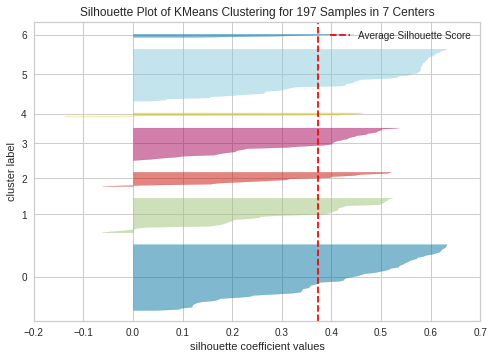

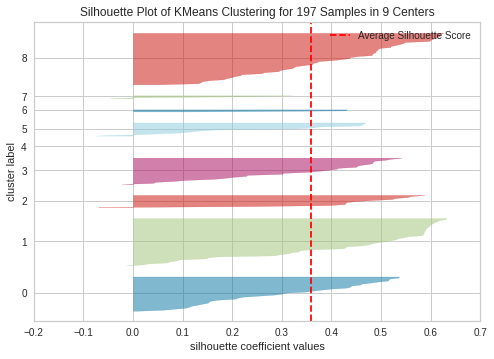

In [208]:
from yellowbrick.cluster import SilhouetteVisualizer
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
for k in range(3,10):
    kms=KMeans(n_clusters=k,random_state=5)
    visualizer = SilhouetteVisualizer(kms, colors='yellowbrick')
    visualizer.fit(scaled_td)
    visualizer.show()

Silhouette score for a set of sample data points is used to measure how dense and well-separated the clusters are.
The value of the Silhouette score varies from -1 to 1. If the score is 1, the cluster is dense and well-separated than other clusters. A value near 0 represents overlapping clusters with samples very close to the decision boundary of the neighboring clusters. A negative score indicates that the samples might have got assigned to the wrong clusters.
It is also a negative symptom if there are clusters below the average silhuette score.
After an intitial assesment we can see that most likely we can disregard options with 3, 4 and 5 clusters considering the following:
* cluster 1 of the 3 clusters option has a large number of samples with a negative score 
* cluster 2 of the 4 clusters option has some number of samples with a negative score and its score is below the average score
* cluster 0 of the 5 clusters option has a significant number of samples with a negative score
Out of the the other options the option with seven clusters looks most promising as it does not have clusters with a significant number of negative scores or clusters with scores below the average score and it has the highest average score out of the options with more clusters then 5.
We will have a better understanding how well each clustering options suits our requirements when we analyse each of the clusters in terms of their demographics.


In [209]:
demogr_sf_res_avg.describe()

avg_hisp  avg_inc_above_100k  avg_30-49_pop   land_area
count    197.000000          197.000000     197.000000  197.000000
mean    4944.686772        15457.786199   10577.024629    0.237933
std     6420.243833        10152.912164    8075.466483    0.278395
min        0.000000            0.000000       0.000000    0.000000
25%     1450.268496         9008.583807    5873.239622    0.113413
50%     2914.469614        13853.137914    9203.147634    0.158258
75%     5439.174669        20435.035732   13164.907394    0.254182
max    39646.417008        67092.308299   57851.690639    2.358635

I will generate cluster labeles for each of the clustering options.

In [210]:
from sklearn.cluster import KMeans
def gen_clusters(l=3,h=9):
    for k in range(l,h+1):
        kms=KMeans(n_clusters=k,random_state=5).fit(scaled_td)
        demogr_sf_res_avg[[str(k)+'_clusters']]=kms.labels_

           

In [211]:

gen_clusters()
demogr_sf_res_avg

trctid     avg_hisp  avg_inc_above_100k  avg_30-49_pop  land_area  \
0    06075010100   927.280282         5693.425998    5220.121250   0.299801   
1    06075010200   673.152074        15463.014831    8027.589366   0.199064   
2    06075010300  3910.093326        21586.323342   16364.464002   0.103578   
3    06075010400  4204.300087        24951.551587   15598.339407   0.129629   
4    06075010500  1087.266095         6478.947501    3231.491081   0.263965   
..           ...          ...                 ...            ...        ...   
192  06075980401     0.000000            0.000000       0.000000   0.161902   
193  06075980501   240.195549          399.304688     189.542075   0.612001   
194  06075980600   108.103664          253.140225     155.474939   0.823284   
195  06075980900    41.886091          109.228813     110.492619   1.384708   
196  06075990100     0.000000            0.000000       0.000000   0.000000   

     3_clusters  4_clusters  5_clusters  6_clusters  7_clusters  8_clusters  \
0             0           3           1           0           5           6   
1             0           3           2           5           0           4   
2             1           0           2           1           1           0   
3             1           0           2           1           1           0   
4             0           3           1           0           5           6   
..          ...         ...         ...         ...         ...         ...   
192           0           3           1           0           5           6   
193           0           3           1           0           5           6   
194           0           3           1           0           5           6   
195           0           3           1           0           5           6   
196           0           3           1           0           5           6   

     9_clusters  
0             1  
1             8  
2             0  
3             0  
4             1  
..          ...  
192           1  
193           1  
194           1  
195           1  
196           1  

[197 rows x 12 columns]

In [271]:
 def eval_clusters(df=demogr_sf_res_avg,l=3,h=9):
        ev_clusters=pd.DataFrame()
        for k in range(l,h+1):
            if ev_clusters.empty:
                ev_clusters= df.groupby([str(k)+'_clusters']).agg({
                'avg_hisp': 'mean',
                'avg_inc_above_100k': 'mean',
                'avg_30-49_pop': 'mean',
                'land_area': sum
                })
                ev_clusters['nr_of_clusters']='_of_'+str(k)+'_clusters'           
            else:
                next_df=df.groupby([str(k)+'_clusters']).agg({
                'avg_hisp': 'mean',
                'avg_inc_above_100k': 'mean',
                'avg_30-49_pop': 'mean',
                'land_area': sum
                })
                next_df['nr_of_clusters']='_of_'+str(k)+'_clusters'
                ev_clusters=pd.concat([ev_clusters,next_df])
                
        ev_clusters.rename(columns={'land_area':'cluster_land_area_sum'},inplace=True)
        ev_clusters.reset_index(inplace=True)
        ev_clusters.rename(columns={'index':'cluster_nr'},inplace=True)
        #ev_clusters['avg_dem']=  ev_clusters['avg_hisp']+ev_clusters['avg_inc_above_100k']+ev_clusters['avg_30-49_pop']
        ev_clusters['avg_dem']=ev_clusters[['avg_hisp','avg_inc_above_100k','avg_30-49_pop']].mean(axis=1)
        #ev_clusters['sort_param']=ev_clusters['sort_param']*ev_clusters['cluster_land_area_sum']
        ev_clusters=ev_clusters.sort_values(by='avg_dem',ascending=False)
        ev_clusters['cluster']=ev_clusters['cluster_nr'].astype(str)+ev_clusters['nr_of_clusters']
        ev_clusters.drop(['cluster_nr','nr_of_clusters'],axis=1,inplace=True)
        ev_clusters.drop(['avg_dem'],axis=1,inplace=True)
        ev_clusters.set_index('cluster',inplace=True,drop=True)
        return(ev_clusters)

Next  using the function defined above I am listing the ten most prefarrable clusters sorted by their suitablity as far as their demographics are concerned.

The darker the color of each of the parameter the tract cluster the more suitable it is for the location of the restaurant.

In [272]:
import seaborn as sns
pd.set_option('display.max_rows', 20)
cm=sns.light_palette('green',as_cmap=True)
ev_cl=eval_clusters().head(10)
ev_cl.style.background_gradient(cmap=cm)


Cluster 4 of 9 clusters has the most beneficial demographics parameters but it has also the smallest area which is disadvantageous.

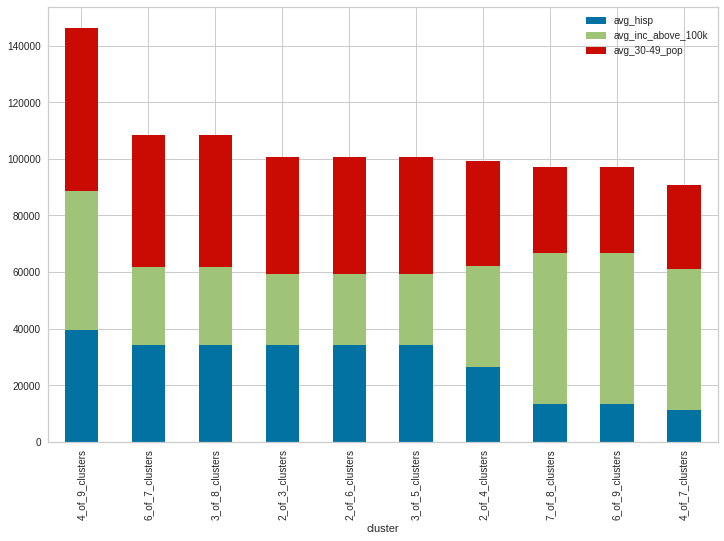

In [216]:
ax=ev_cl.iloc[:,:-1].plot(kind='bar',stacked=True,figsize=(12,8))
#ev_cl.iloc[:,-1].plot(figsize=(12,8))

<AxesSubplot:xlabel='cluster'>

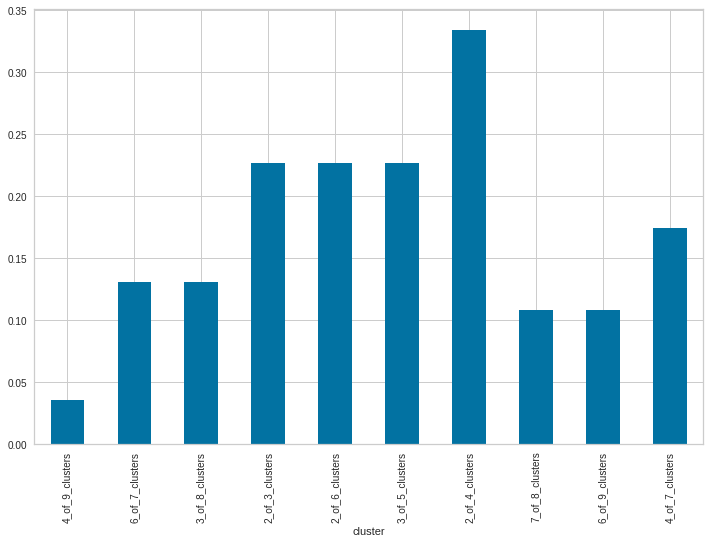

In [217]:
ev_cl.iloc[:,-1].plot(kind='bar',figsize=(12,8))

In [218]:
ev_cl.describe()

avg_hisp  avg_inc_above_100k  avg_30-49_pop  cluster_land_area_sum
count     10.000000           10.000000      10.000000              10.000000
mean   27550.789194        37083.835087   40386.344627               0.170087
std    10763.167135        12661.154324    8855.010548               0.085424
min    11193.239330        25064.500605   29792.675621               0.035539
25%    16661.201315        25660.590664   32255.629997               0.113350
50%    34235.765618        31528.786143   41358.848581               0.152470
75%    34314.647883        49625.296121   45473.410791               0.226749
max    39646.417008        53182.396179   57851.690639               0.334371

In [219]:
demogr_sf_res_avg[demogr_sf_res_avg['9_clusters']==4]

trctid      avg_hisp  avg_inc_above_100k  avg_30-49_pop  land_area  \
19  06075012201  39646.417008        48909.843114   57851.690639   0.035539   

    3_clusters  4_clusters  5_clusters  6_clusters  7_clusters  8_clusters  \
19           2           2           3           2           6           3   

    9_clusters  
19           4

#### In case of the 6 clusters option cluster nr 4 is most preferable as it has the largest number inhabitants of Hispanic origin, with income above 100k and average 20-49 population per square mile.

#### In case of the 4 clusters option cluster nr 3 is most preferable.

#### In case of the 7 clusters option cluster nr 3 is most preferable.

#### In case of clustering in 4 clusters the most prefered cluster has fewer average number of inhabitants per sqaure mile that fulfill our requirements then the best cluster in the 6 and 7 clusters options. Considering the 6 and 7 cluster options have the same average number of inhabitants per square mile that meet our prerequisites we will select the option with 6 clusters.   

In [258]:
#html template code for map legend
template = """
{% macro html(this, kwargs) %}

<!doctype html>
<html lang="en">
<head>
  <meta charset="utf-8">
  <meta name="viewport" content="width=device-width, initial-scale=1">
  <title>jQuery UI Draggable - Default functionality</title>
  <link rel="stylesheet" href="//code.jquery.com/ui/1.12.1/themes/base/jquery-ui.css">

  <script src="https://code.jquery.com/jquery-1.12.4.js"></script>
  <script src="https://code.jquery.com/ui/1.12.1/jquery-ui.js"></script>
  
  <script>
  $( function() {
    $( "#maplegend" ).draggable({
                    start: function (event, ui) {
                        $(this).css({
                            right: "auto",
                            top: "auto",
                            bottom: "auto"
                        });
                    }
                });
});

  </script>
</head>
<body>

 
<div id='maplegend' class='maplegend' 
    style='position: absolute; z-index:9999; border:2px solid grey; background-color:rgba(255, 255, 255, 0.8);
     border-radius:6px; padding: 10px; font-size:14px; right: 20px; bottom: 20px;'>
     
<div class='legend-title'>Legend (draggable)</div>
<div class='legend-title'>9 clusters)</div>
<div class='legend-scale'>
  <ul class='legend-labels'>
    <li><span style='background:black;opacity:0.7;'></span>Cluster 0</li>
    <li><span style='background:red;opacity:0.7;'></span>Cluster 1</li>
    <li><span style='background:blue;opacity:0.7;'></span>Cluster 2</li>
    <li><span style='background:darkred;opacity:0.7;'></span>Cluster 3</li>
    <li><span style='background:yellow;opacity:0.7;'></span>Cluster 4</li>
    <li><span style='background:gray;opacity:0.7;'></span>Cluster 5</li>
    <li><span style='background:green;opacity:0.7;'></span>Cluster 6</li>
    <li><span style='background:cadetblue;opacity:0.7;'></span>Cluster 7</li>
    <li><span style='background:purple;opacity:0.7;'></span>Cluster 8</li>
  
  </ul>
</div>
</div>
 
</body>
</html>

<style type='text/css'>
  .maplegend .legend-title {
    text-align: left;
    margin-bottom: 5px;
    font-weight: bold;
    font-size: 90%;
    }
  .maplegend .legend-scale ul {
    margin: 0;
    margin-bottom: 5px;
    padding: 0;
    float: left;
    list-style: none;
    }
  .maplegend .legend-scale ul li {
    font-size: 80%;
    list-style: none;
    margin-left: 0;
    line-height: 18px;
    margin-bottom: 2px;
    }
  .maplegend ul.legend-labels li span {
    display: block;
    float: left;
    height: 16px;
    width: 30px;
    margin-right: 5px;
    margin-left: 0;
    border: 1px solid #999;
    }
  .maplegend .legend-source {
    font-size: 80%;
    color: #777;
    clear: both;
    }
  .maplegend a {
    color: #777;
    }
</style>
{% endmacro %}"""

In [221]:
demogr_sf_res

trctid  popden13_17  phispanic13_17  inc_above_100k  30-49_pop  \
0    06075010100   13232.0900        0.070078        0.430274   0.394505   
1    06075010200   21917.6300        0.030713        0.705506   0.366262   
2    06075010300   42257.9700        0.092529        0.510823   0.387252   
3    06075010400   35832.9800        0.117330        0.696329   0.435307   
4    06075010500   10194.5400        0.106652        0.635531   0.316983   
..           ...          ...             ...             ...        ...   
192  06075980401       0.0000        0.000000        0.000000   0.000000   
193  06075980501    1277.7750        0.187980        0.312500   0.148338   
194  06075980600     623.1144        0.173489        0.406250   0.249513   
195  06075980900     174.7661        0.239669        0.625000   0.632231   
196  06075990100       0.0000        0.000000        0.000000   0.000000   

     land_area  
0     0.299801  
1     0.199064  
2     0.103578  
3     0.129629  
4     0.263965  
..         ...  
192   0.161902  
193   0.612001  
194   0.823284  
195   1.384708  
196   0.000000  

[197 rows x 6 columns]

In [267]:
import geopandas as gpd

geosan = gpd.read_file(r'__San_Francisco_Bay_Region_2010_Census_Tracts_(clipped).geojson', driver='GeoJSON')
demogr_sf_res.rename(columns={'tract_fips10':'trctid'},inplace=True)
geosan=pd.merge(geosan,demogr_sf_res,how='right',on='trctid')

geosan

objectid fipst fipco       trctid              trctname  Shape__Area  \
0       664.0    06   075  06075010100      Census Tract 101     0.000079   
1       665.0    06   075  06075010200      Census Tract 102     0.000053   
2       666.0    06   075  06075010300      Census Tract 103     0.000027   
3       667.0    06   075  06075010400      Census Tract 104     0.000034   
4       668.0    06   075  06075010500      Census Tract 105     0.000070   
..        ...   ...   ...          ...                   ...          ...   
192     856.0    06   075  06075980401  Census Tract 9804.01     0.000043   
193     857.0    06   075  06075980501  Census Tract 9805.01     0.000162   
194     858.0    06   075  06075980600     Census Tract 9806     0.000218   
195     859.0    06   075  06075980900     Census Tract 9809     0.000367   
196       NaN   NaN   NaN  06075990100                   NaN          NaN   

     Shape__Length                                           geometry  \
0         0.214358  POLYGON ((-122.40060 37.80603, -122.40041 37.8...   
1         0.048540  MULTIPOLYGON (((-122.42663 37.80883, -122.4266...   
2         0.022957  POLYGON ((-122.41489 37.80355, -122.41546 37.8...   
3         0.032687  POLYGON ((-122.40243 37.79939, -122.40262 37.8...   
4         0.087869  POLYGON ((-122.39200 37.79388, -122.39169 37.7...   
..             ...                                                ...   
192       0.073780  MULTIPOLYGON (((-123.00361 37.69325, -123.0027...   
193       0.071783  POLYGON ((-122.40668 37.71922, -122.40697 37.7...   
194       0.188398  MULTIPOLYGON (((-122.38681 37.72431, -122.3867...   
195       0.132279  POLYGON ((-122.37413 37.74498, -122.37416 37.7...   
196            NaN                                               None   

     popden13_17  phispanic13_17  inc_above_100k  30-49_pop  land_area  
0     13232.0900        0.070078        0.430274   0.394505   0.299801  
1     21917.6300        0.030713        0.705506   0.366262   0.199064  
2     42257.9700        0.092529        0.510823   0.387252   0.103578  
3     35832.9800        0.117330        0.696329   0.435307   0.129629  
4     10194.5400        0.106652        0.635531   0.316983   0.263965  
..           ...             ...             ...        ...        ...  
192       0.0000        0.000000        0.000000   0.000000   0.161902  
193    1277.7750        0.187980        0.312500   0.148338   0.612001  
194     623.1144        0.173489        0.406250   0.249513   0.823284  
195     174.7661        0.239669        0.625000   0.632231   1.384708  
196       0.0000        0.000000        0.000000   0.000000   0.000000  

[197 rows x 13 columns]

In [273]:
import folium
import branca.colormap as cmp
clusters=demogr_sf_res_avg.set_index('trctid')['9_clusters']+1
step = cmp.StepColormap(
 ['black','red','blue','darkred','yellow','gray','green','cadetblue','purple'],
 vmin=0, vmax=9,
 index=[0,1, 2, 3,4,5,6,7,8,9],  #for change in the colors, not used fr linear
 caption='Clusters'    #Caption for Color scale or Legend
)
sanmap=folium.Map(zoom_start=13,location=[37.77,-122.42])
folium.GeoJson(geosan,style_function=lambda feature: {
    'fillColor':step(clusters[feature['properties']['trctid']]),
    'fillOpacity':0.6,
    'color':'black', #border color for the color fills
    'weight':1, #how thick the border has to be
    'dashArray': '5,3' #dashed lines length,space between them
}).add_to(sanmap)

 
from branca.element import Template, MacroElement

macro = MacroElement()
macro._template = Template(template)

sanmap.get_root().add_child(macro)
sanmap

In [224]:
import folium
import branca.colormap as cmp
clusters=demogr_sf_res_avg.set_index('trctid')['4_clusters']+1
step = cmp.StepColormap(
 ['purple','red','yellow','blue','yellow'],
 vmin=0, vmax=4,
 index=[0,1, 2, 3,4,5],  #for change in the colors, not used fr linear
 caption='Clusters'    #Caption for Color scale or Legend
)
sanmap=folium.Map(zoom_start=13,location=[37.77,-122.42])
folium.GeoJson(geosan,style_function=lambda feature: {
    'fillColor':step(clusters[feature['properties']['trctid']]),
    'fillOpacity':0.5,
    'color':'black', #border color for the color fills
    'weight':1, #how thick the border has to be
    'dashArray': '5,3' #dashed lines length,space between them
}).add_to(sanmap)

step.add_to(sanmap) 
from branca.element import Template, MacroElement

macro = MacroElement()
macro._template = Template(template)

sanmap.get_root().add_child(macro)
sanmap

In [225]:
demogr_sf_res_avg[demogr_sf_res_avg['7_clusters']==5]

trctid     avg_hisp  avg_inc_above_100k  avg_30-49_pop  land_area  \
0    06075010100   927.280282         5693.425998    5220.121250   0.299801   
4    06075010500  1087.266095         6478.947501    3231.491081   0.263965   
13   06075011700  1215.707574         1538.563299    3474.780930   0.214690   
28   06075012602   436.347823         9865.961907    5639.589698   0.242925   
51   06075016100  2211.558779         5035.541071   10931.419418   0.142433   
..           ...          ...                 ...            ...        ...   
192  06075980401     0.000000            0.000000       0.000000   0.161902   
193  06075980501   240.195549          399.304688     189.542075   0.612001   
194  06075980600   108.103664          253.140225     155.474939   0.823284   
195  06075980900    41.886091          109.228813     110.492619   1.384708   
196  06075990100     0.000000            0.000000       0.000000   0.000000   

     3_clusters  4_clusters  5_clusters  6_clusters  7_clusters  8_clusters  \
0             0           3           1           0           5           6   
4             0           3           1           0           5           6   
13            0           3           1           0           5           6   
28            0           3           1           0           5           4   
51            0           3           1           0           5           4   
..          ...         ...         ...         ...         ...         ...   
192           0           3           1           0           5           6   
193           0           3           1           0           5           6   
194           0           3           1           0           5           6   
195           0           3           1           0           5           6   
196           0           3           1           0           5           6   

     9_clusters  
0             1  
4             1  
13            1  
28            1  
51            1  
..          ...  
192           1  
193           1  
194           1  
195           1  
196           1  

[49 rows x 12 columns]

In [229]:
import folium
import branca.colormap as cmp
clusters=demogr_sf_res_avg.set_index('trctid')['7_clusters']+1
step = cmp.StepColormap(
 ['purple','red','blue','darkred','black','gray','yellow'],
 vmin=0, vmax=7,
 index=[0,1, 2, 3,4,5,6,7],  #for change in the colors, not used fr linear
 caption='Clusters'    #Caption for Color scale or Legend
)
sanmap=folium.Map(zoom_start=13,location=[37.77,-122.42])
folium.GeoJson(geosan,style_function=lambda feature: {
    'fillColor':step(clusters[feature['properties']['trctid']]),
    'fillOpacity':0.6,
    'color':'black', #border color for the color fills
    'weight':1, #how thick the border has to be
    'dashArray': '5,3' #dashed lines length,space between them
}).add_to(sanmap)

step.add_to(sanmap) 
from branca.element import Template, MacroElement

macro = MacroElement()
macro._template = Template(template)

sanmap.get_root().add_child(macro)
sanmap

In [227]:
scaled_df=pd.DataFrame(scaled_td,columns=['avg_hisp','avg_inc_above_100k','avg_30-40_pop'])
scaled_df['tractid']=demogr_sf_res_avg['trctid']
scaled_df

avg_hisp  avg_inc_above_100k  avg_30-40_pop      tractid
0    0.023389            0.084860       0.090233  06075010100
1    0.016979            0.230474       0.138762  06075010200
2    0.098624            0.321741       0.282869  06075010300
3    0.106045            0.371899       0.269626  06075010400
4    0.027424            0.096568       0.055858  06075010500
..        ...                 ...            ...          ...
192  0.000000            0.000000       0.000000  06075980401
193  0.006058            0.005952       0.003276  06075980501
194  0.002727            0.003773       0.002687  06075980600
195  0.001056            0.001628       0.001910  06075980900
196  0.000000            0.000000       0.000000  06075990100

[197 rows x 4 columns]

In [228]:
scaled_df['suitability']=scaled_df['avg_inc_above_100k']*0.45+scaled_df['avg_hisp']*0.35+scaled_df['avg_30-40_pop']*0.2
scaled_df['tractid']=demogr_sf_res_avg['trctid']
scaled_df['clusters']=demogr_sf_res_avg['clusters']
scaled_df

KeyError: 'clusters'

In [ ]:
pd.set_option('display.max_rows', 20)
scaled_df.sort_values(by='suitability',ascending=False).head(20)

In [ ]:
scaled_df.groupby('clusters').mean()

In [ ]:
scaled_df.describe()

In [ ]:
scaled_df

In [ ]:
import folium

sanmap=folium.Map(zoom_start=13,location=[37.77,-122.42])
sanmap.choropleth(geo_data=geosan,data=scaled_df,columns=['tractid','suitability'],
                  key_on='feature.properties.trctid',fill_color='YlOrRd',legend_name="Suitability",fill_opacity=0.7,line_opacity=0.2)

sanmap

In [ ]:
scaled_df_5_3=scaled_df[(scaled_df['clusters']==3) |  (scaled_df['clusters']==5) ]
scaled_df_5_3

In [ ]:
scaled_df_5=scaled_df[(scaled_df['clusters']==5) ]
scaled_df_5

In [ ]:
import folium

sanmap=folium.Map(zoom_start=13,location=[37.77,-122.42])
sanmap.choropleth(geo_data=geosan,data=scaled_df_5_3,columns=['tractid','suitability'],
                  key_on='feature.properties.trctid',fill_color='YlOrRd',legend_name="Suitability",fill_opacity=0.7,line_opacity=0.2)

sanmap

In [ ]:
cluster_6_dem=demogr_sf_res_avg[demogr_sf_res_avg['7_clusters']==6]
cluster_6_dem

Reading information about California census tracts.


In [ ]:
ca_tracts=pd.read_csv('2019_gaz_tracts_06.txt',delimiter='\t',dtype={'GEOID': str})
ca_tracts

Subsetting information about California census tracts to San Francisco tracts.


In [ ]:
ca_tracts['trint']=ca_tracts['GEOID'].astype(int)
sf_tracts=ca_tracts[(ca_tracts['trint']<=6075990100) & (ca_tracts['trint']>=6075010100)]
sf_tracts.drop(columns=['trint'],inplace=True)
sf_tracts.reset_index(drop=True,inplace=True)

sf_tracts.rename(columns={'INTPTLAT':'Lat',
                          'INTPTLONG                                                                                                                             ':'Lon'},inplace=True)
#sf_tracts['Tract Code']=sf_tracts['Tract Code']-6075000000
sf_tracts.drop(columns='USPS',inplace=True)
sf_tracts

In [ ]:
sf_tracts.rename(columns={'GEOID':'trctid'},inplace=True)
sf_tracts

In [ ]:
cluster_6_dem=pd.merge(cluster_6_dem,sf_tracts,how='left',on='trctid')
cluster_6_dem

In [ ]:
cluster_6_dem.describe()

In [115]:
CLIENT_ID = 'X' # your Foursquare ID
CLIENT_SECRET = 'X' # your Foursquare Secret
ACCESS_TOKEN = 'X' # your FourSquare Access Token
VERSION = '20180604'
LIMIT = 100

In [116]:
def getNearbyVenues(names,categories, latitudes, longitudes, radius=700):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&categoryId={}&radius={}&limit={}'.format(
                       CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            categories,
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]["groups"][0]["items"]
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['id'], 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name'],
            v['venue']['categories'][0]['id'],
        ) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list],columns = [
                  'trctid', 
                  'Tract Latitude', 
                  'Tract Longitude',
                  'Venue Id',
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category',
                  'Venue Category ID'
    ])
       
    return(nearby_venues)

In [134]:
import requests
names= cluster_6_dem.loc[:,'trctid']
longitudes= cluster_6_dem['Lon']
latitudes= cluster_6_dem['Lat']

food_cat='4d4b7105d754a06374d81259' #Foursquare Foof category

cl6_venues= getNearbyVenues(names,food_cat,latitudes, longitudes)
cl6_venues

06075012201
06075012202
06075012401
06075012502


trctid  Tract Latitude  Tract Longitude                  Venue Id  \
0    06075012201       37.785846      -122.416353  49dd8602f964a52018601fe3   
1    06075012201       37.785846      -122.416353  56b4af45498e429dd2223d46   
2    06075012201       37.785846      -122.416353  59a0d46475eee41c2c7589e3   
3    06075012201       37.785846      -122.416353  56a7f7fa498e29aaf707c5d4   
4    06075012201       37.785846      -122.416353  49e8affef964a52069651fe3   
..           ...             ...              ...                       ...   
389  06075012502       37.783933      -122.412595  4bcdc820b6c49c74cde19591   
390  06075012502       37.783933      -122.412595  584b9645e9efba2d70076018   
391  06075012502       37.783933      -122.412595  49c2be75f964a52026561fe3   
392  06075012502       37.783933      -122.412595  44e36f32f964a52041371fe3   
393  06075012502       37.783933      -122.412595  4d24b237daa937040cc5c781   

                       Venue  Venue Latitude  Venue Longitude  \
0              Lers Ros Thai       37.784759      -122.417811   
1               Mensho Tokyo       37.786553      -122.414289   
2                     Bandit       37.786469      -122.414462   
3                    Tselogs       37.786479      -122.413128   
4          Angel Cafe & Deli       37.786612      -122.414979   
..                       ...             ...              ...   
389            Daniel's Café       37.785283      -122.408879   
390  Bota Tapas & Paella Bar       37.786974      -122.411248   
391       Boudin Bakery Café       37.786647      -122.407307   
392                Gyro King       37.778762      -122.415713   
393          Pinecrest Diner       37.786997      -122.410027   

               Venue Category         Venue Category ID  
0             Thai Restaurant  4bf58dd8d48988d149941735  
1            Ramen Restaurant  55a59bace4b013909087cb24  
2                Burger Joint  4bf58dd8d48988d16c941735  
3         Filipino Restaurant  4eb1bd1c3b7b55596b4a748f  
4                        Café  4bf58dd8d48988d16d941735  
..                        ...                       ...  
389                      Café  4bf58dd8d48988d16d941735  
390         Paella Restaurant  4bf58dd8d48988d14d941735  
391                    Bakery  4bf58dd8d48988d16a941735  
392  Mediterranean Restaurant  4bf58dd8d48988d1c0941735  
393                     Diner  4bf58dd8d48988d147941735  

[394 rows x 9 columns]

In [135]:
cl6_venues.to_feather('cl6_venues.fea')

In [136]:
cl6_venues.drop_duplicates(subset='Venue Id',ignore_index=True,inplace=True)
cl6_venues

trctid  Tract Latitude  Tract Longitude                  Venue Id  \
0    06075012201       37.785846      -122.416353  49dd8602f964a52018601fe3   
1    06075012201       37.785846      -122.416353  56b4af45498e429dd2223d46   
2    06075012201       37.785846      -122.416353  59a0d46475eee41c2c7589e3   
3    06075012201       37.785846      -122.416353  56a7f7fa498e29aaf707c5d4   
4    06075012201       37.785846      -122.416353  49e8affef964a52069651fe3   
..           ...             ...              ...                       ...   
158  06075012502       37.783933      -122.412595  4ab91f03f964a520167e20e3   
159  06075012502       37.783933      -122.412595  4b805303f964a5200b6830e3   
160  06075012502       37.783933      -122.412595  42e03700f964a52063261fe3   
161  06075012502       37.783933      -122.412595  5a0522a83af988764605d1dc   
162  06075012502       37.783933      -122.412595  49c2be75f964a52026561fe3   

                       Venue  Venue Latitude  Venue Longitude  \
0              Lers Ros Thai       37.784759      -122.417811   
1               Mensho Tokyo       37.786553      -122.414289   
2                     Bandit       37.786469      -122.414462   
3                    Tselogs       37.786479      -122.413128   
4          Angel Cafe & Deli       37.786612      -122.414979   
..                       ...             ...              ...   
158            Latte Express       37.783254      -122.407215   
159            Auntie Anne's       37.784449      -122.406612   
160  Morton's The Steakhouse       37.788408      -122.408976   
161             Koja Kitchen       37.784322      -122.406067   
162       Boudin Bakery Café       37.786647      -122.407307   

          Venue Category         Venue Category ID  
0        Thai Restaurant  4bf58dd8d48988d149941735  
1       Ramen Restaurant  55a59bace4b013909087cb24  
2           Burger Joint  4bf58dd8d48988d16c941735  
3    Filipino Restaurant  4eb1bd1c3b7b55596b4a748f  
4                   Café  4bf58dd8d48988d16d941735  
..                   ...                       ...  
158       Sandwich Place  4bf58dd8d48988d1c5941735  
159          Snack Place  4bf58dd8d48988d1c7941735  
160           Steakhouse  4bf58dd8d48988d1cc941735  
161    Korean Restaurant  4bf58dd8d48988d113941735  
162               Bakery  4bf58dd8d48988d16a941735  

[163 rows x 9 columns]

In [137]:
cl6_venues['Venue Category'].unique()

array(['Thai Restaurant', 'Ramen Restaurant', 'Burger Joint',
       'Filipino Restaurant', 'Café', 'Vietnamese Restaurant',
       'Hawaiian Restaurant', 'Ethiopian Restaurant', 'Sushi Restaurant',
       'Sandwich Place', 'Bakery', 'Korean Restaurant', 'Gastropub',
       'Mexican Restaurant', 'Southern / Soul Food Restaurant',
       'Breakfast Spot', 'Indian Restaurant', 'Italian Restaurant',
       'Afghan Restaurant', 'Yemeni Restaurant', 'BBQ Joint',
       'Deli / Bodega', 'Vegetarian / Vegan Restaurant', 'Pizza Place',
       'Diner', 'Japanese Restaurant', 'American Restaurant',
       'Seafood Restaurant', 'Moroccan Restaurant',
       'Mediterranean Restaurant', 'French Restaurant',
       'Hotpot Restaurant', 'Food Truck', 'Restaurant', 'Burrito Place',
       'Steakhouse', 'Middle Eastern Restaurant',
       'New American Restaurant', 'Paella Restaurant',
       'South Indian Restaurant', 'Donut Shop', 'Chinese Restaurant',
       'Asian Restaurant', 'Taco Place', 'Burmes

In [138]:
other_food_cat=['Café','Bakery','Food Truck','Donut Shop','Snack Place']   
cl6_res=cl6_venues.drop(index=cl6_venues[cl6_venues['Venue Category'].isin(other_food_cat)].index)


In [127]:
cl6_res

trctid  Tract Latitude  Tract Longitude                  Venue Id  \
0    06075012201       37.785846      -122.416353  49dd8602f964a52018601fe3   
1    06075012201       37.785846      -122.416353  56b4af45498e429dd2223d46   
2    06075012201       37.785846      -122.416353  59a0d46475eee41c2c7589e3   
3    06075012201       37.785846      -122.416353  56a7f7fa498e29aaf707c5d4   
5    06075012201       37.785846      -122.416353  4ae65f18f964a520bda621e3   
..           ...             ...              ...                       ...   
153  06075012502       37.783933      -122.412595  4dfd856d483b96a3aaa9eb34   
157  06075012502       37.783933      -122.412595  4af09c87f964a520a1dd21e3   
158  06075012502       37.783933      -122.412595  4ab91f03f964a520167e20e3   
160  06075012502       37.783933      -122.412595  42e03700f964a52063261fe3   
161  06075012502       37.783933      -122.412595  5a0522a83af988764605d1dc   

                       Venue  Venue Latitude  Venue Longitude  \
0              Lers Ros Thai       37.784759      -122.417811   
1               Mensho Tokyo       37.786553      -122.414289   
2                     Bandit       37.786469      -122.414462   
3                    Tselogs       37.786479      -122.413128   
5                   Phở 2000       37.783896      -122.417787   
..                       ...             ...              ...   
153              Box Kitchen       37.781158      -122.406243   
157                      Tín       37.780840      -122.405770   
158            Latte Express       37.783254      -122.407215   
160  Morton's The Steakhouse       37.788408      -122.408976   
161             Koja Kitchen       37.784322      -122.406067   

            Venue Category         Venue Category ID  
0          Thai Restaurant  4bf58dd8d48988d149941735  
1         Ramen Restaurant  55a59bace4b013909087cb24  
2             Burger Joint  4bf58dd8d48988d16c941735  
3      Filipino Restaurant  4eb1bd1c3b7b55596b4a748f  
5    Vietnamese Restaurant  4bf58dd8d48988d14a941735  
..                     ...                       ...  
153    American Restaurant  4bf58dd8d48988d14e941735  
157  Vietnamese Restaurant  4bf58dd8d48988d14a941735  
158         Sandwich Place  4bf58dd8d48988d1c5941735  
160             Steakhouse  4bf58dd8d48988d1cc941735  
161      Korean Restaurant  4bf58dd8d48988d113941735  

[136 rows x 9 columns]

In [139]:

mex_categories=['4bf58dd8d48988d1c1941735','58daa1558bbb0b01f18ec1d9',
            '4bf58dd8d48988d153941735','4bf58dd8d48988d151941735',
            '56aa371ae4b08b9a8d5734ba','5744ccdfe4b0c0459246b4d3'
             ] #Foursquare Mexican Restaurants categories
mex_venues=cl6_venues[cl6_venues['Venue Category ID'].isin(mex_categories)].reset_index()
mex_venues

index       trctid  Tract Latitude  Tract Longitude  \
0     19  06075012201       37.785846      -122.416353   
1     71  06075012201       37.785846      -122.416353   
2     74  06075012201       37.785846      -122.416353   
3     97  06075012201       37.785846      -122.416353   
4    115  06075012202       37.785412      -122.419644   
5    123  06075012202       37.785412      -122.419644   
6    145  06075012401       37.783051      -122.415789   

                   Venue Id                   Venue  Venue Latitude  \
0  59cb288d6c08d172265a8e6d                  Chisme       37.788467   
1  49e4f160f964a52074631fe3         Taqueria Cancun       37.781875   
2  51b28827498ef0351235c618           El Castillito       37.781961   
3  4550e681f964a520e43c1fe3  Colibrí Mexican Bistro       37.787109   
4  4b524b07f964a5205f7527e3  Taqueria El Castillito       37.781569   
5  4a7b2e4ff964a52037ea1fe3         Taqueria La Paz       37.783328   
6  4a846e6cf964a52094fc1fe3    Taqueria Castillo B2       37.783778   

   Venue Longitude      Venue Category         Venue Category ID  
0      -122.414802  Mexican Restaurant  4bf58dd8d48988d1c1941735  
1      -122.410322       Burrito Place  4bf58dd8d48988d153941735  
2      -122.414737  Mexican Restaurant  4bf58dd8d48988d1c1941735  
3      -122.410533  Mexican Restaurant  4bf58dd8d48988d1c1941735  
4      -122.416897       Burrito Place  4bf58dd8d48988d153941735  
5      -122.413703          Taco Place  4bf58dd8d48988d151941735  
6      -122.409030       Burrito Place  4bf58dd8d48988d153941735

In [140]:
def add_color(venue):
    if venue=='Mexican Restaurant':
        color='red'
    elif venue=='Taco Place':
        color='purple'
    elif venue=='Burrito Place':
        color='orange'
    else:
        color='blue'
    return color
cl6_res['color']=cl6_res.apply(lambda x: add_color(x["Venue Category"]),axis=1)
cl6_res
                                                 
    


trctid  Tract Latitude  Tract Longitude                  Venue Id  \
0    06075012201       37.785846      -122.416353  49dd8602f964a52018601fe3   
1    06075012201       37.785846      -122.416353  56b4af45498e429dd2223d46   
2    06075012201       37.785846      -122.416353  59a0d46475eee41c2c7589e3   
3    06075012201       37.785846      -122.416353  56a7f7fa498e29aaf707c5d4   
5    06075012201       37.785846      -122.416353  4ae65f18f964a520bda621e3   
..           ...             ...              ...                       ...   
153  06075012502       37.783933      -122.412595  4dfd856d483b96a3aaa9eb34   
157  06075012502       37.783933      -122.412595  4af09c87f964a520a1dd21e3   
158  06075012502       37.783933      -122.412595  4ab91f03f964a520167e20e3   
160  06075012502       37.783933      -122.412595  42e03700f964a52063261fe3   
161  06075012502       37.783933      -122.412595  5a0522a83af988764605d1dc   

                       Venue  Venue Latitude  Venue Longitude  \
0              Lers Ros Thai       37.784759      -122.417811   
1               Mensho Tokyo       37.786553      -122.414289   
2                     Bandit       37.786469      -122.414462   
3                    Tselogs       37.786479      -122.413128   
5                   Phở 2000       37.783896      -122.417787   
..                       ...             ...              ...   
153              Box Kitchen       37.781158      -122.406243   
157                      Tín       37.780840      -122.405770   
158            Latte Express       37.783254      -122.407215   
160  Morton's The Steakhouse       37.788408      -122.408976   
161             Koja Kitchen       37.784322      -122.406067   

            Venue Category         Venue Category ID color  
0          Thai Restaurant  4bf58dd8d48988d149941735  blue  
1         Ramen Restaurant  55a59bace4b013909087cb24  blue  
2             Burger Joint  4bf58dd8d48988d16c941735  blue  
3      Filipino Restaurant  4eb1bd1c3b7b55596b4a748f  blue  
5    Vietnamese Restaurant  4bf58dd8d48988d14a941735  blue  
..                     ...                       ...   ...  
153    American Restaurant  4bf58dd8d48988d14e941735  blue  
157  Vietnamese Restaurant  4bf58dd8d48988d14a941735  blue  
158         Sandwich Place  4bf58dd8d48988d1c5941735  blue  
160             Steakhouse  4bf58dd8d48988d1cc941735  blue  
161      Korean Restaurant  4bf58dd8d48988d113941735  blue  

[136 rows x 10 columns]

In [ ]:
import folium

sanmap=folium.Map(zoom_start=15.5,location=[37.78646,-122.414462])
folium.Choropleth(geo_data=geosan[geosan['clusters']==5],data=scaled_df_5_3,columns=['tractid','suitability'],
                  key_on='feature.properties.trctid',fill_color='YlOrRd',legend_name="Suitability",fill_opacity=0.6,line_opacity=0.2).add_to(sanmap)
for i in range(0,len(cl5_res)):
    folium.Marker(location=[cl5_res.iloc[i]['Venue Latitude'],cl5_res.iloc[i]['Venue Longitude']],
                  popup=cl5_res.iloc[i]['Venue Category']+ '<br>' +cl5_res.iloc[i]['Venue'],icon = folium.Icon(color = "%s" % cl5_res.iloc[i]['color'])).add_to(sanmap)
    
#sanmap.GeoJson(cl5_res,name='CLuster 5 restaurants',tooltip=folium.GeoJsonTooltip(fields=['Venue Category','Venue']))
sanmap

In [ ]:
#cl5_res.to_feather("cl5_res.fea")

In [142]:
import folium
import branca.colormap as cmp
sanmap=folium.Map(zoom_start=15.5,location=[37.78646,-122.414462])
clusters=demogr_sf_res_avg.set_index('trctid')['7_clusters']+1
step = cmp.StepColormap(
 ['purple','red','blue','darkred','black','gray','green'],
 vmin=0, vmax=7,
 index=[0,1, 2, 3,4,5,6],  #for change in the colors, not used fr linear
 caption='Clusters'    #Caption for Color scale or Legend
)

folium.GeoJson(geosan,style_function=lambda feature: {
    'fillColor':step(clusters[feature['properties']['trctid']]),
    'fillOpacity':0.4,
    'color':'black', #border color for the color fills
    'weight':1, #how thick the border has to be
    'dashArray': '5,3' #dashed lines length,space between them
}).add_to(sanmap)

step.add_to(sanmap) 
from branca.element import Template, MacroElement

macro = MacroElement()
macro._template = Template(template)

sanmap.get_root().add_child(macro)
for i in range(0,len(cl6_res)):
    folium.Marker(location=[cl6_res.iloc[i]['Venue Latitude'],cl6_res.iloc[i]['Venue Longitude']],
                  popup=cl6_res.iloc[i]['Venue Category']+ '<br>' +cl6_res.iloc[i]['Venue'],
                  icon = folium.Icon(color = "%s" % cl6_res.iloc[i]['color'])).add_to(sanmap)
sanmap